# Pytorch LSTM Stock Predictor


## Step 1: Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('all_stocks_5yr.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [4]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
data.tail()

,date,open,high,low,close,volume,Name
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


In [6]:
apl_close = data[data['Name']=='AAPL'].close.values

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
apl_close = apl_close.reshape(apl_close.shape[0], 1)
apl = sc.fit_transform(apl_close)

## Step 2:  Cutting time series into sequences

Time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{p}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $p$ is the total length of the series.  In order to treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) to produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  So a time series of length P and window size T = 5 as shown above can create P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

 

In [8]:
# Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(apl, 7)


In [9]:
print(len(apl), len(X), len(y))

1259 1251 1251


In [10]:
X.shape

(1251, 7)

## Step 3: Train/Test split

In order to perform proper testing on our dataset I lop off the last 1/3 of it for validation (or testing).  

Note it is **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because the input/output pairs *are related temporally*.  I don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that  receiving new points *within the timeframe of our training set*.  

The right way is to train on one solid chunk of the series (in this case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how the model would predict *future* values of a time series.

In [11]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [12]:
X_train.shape

(1000, 1, 7)

In [13]:
y_train.shape

(1000,)

## Step 4: Model building

Build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [14]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)

        outs = self.out(r_out)

        return outs, hidden_state

In [15]:
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
# BATCH_SIZE = 128

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
# device = torch.device("mps")
# rnn.to(device)

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [16]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
history = []
history_eval_loss = []
X_test_cuda = torch.tensor(X_test).float()
y_test_cuda = torch.tensor(y_test).float()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float()
labels_cuda = torch.tensor(y_train).float()

for epoch in range(300):
    # rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     
    optimiser.step()                    

    if epoch % 20 == 0:
        with torch.no_grad():
            test_output, _ = rnn(X_test_cuda, hidden_state)
            test_loss = criterion(test_output.view(-1), y_test_cuda)
            print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
            history_eval_loss.append(test_loss.item())
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.11432524770498276, eval loss 0.5439240336418152
epoch 1, loss 0.09737362712621689
epoch 2, loss 0.08184375613927841
epoch 3, loss 0.06767711043357849
epoch 4, loss 0.05457639321684837
epoch 5, loss 0.04277407377958298
epoch 6, loss 0.033277884125709534
epoch 7, loss 0.026785125955939293
epoch 8, loss 0.024906979873776436
epoch 9, loss 0.02915051020681858
epoch 10, loss 0.03396366164088249
epoch 11, loss 0.03449462354183197
epoch 12, loss 0.03139964118599892
epoch 13, loss 0.027433129027485847
epoch 14, loss 0.02447742596268654
epoch 15, loss 0.022968685254454613
epoch 16, loss 0.022442780435085297
epoch 17, loss 0.02258235029876232
epoch 18, loss 0.02305006794631481
epoch 19, loss 0.02328355237841606
epoch 20, loss 0.023233089596033096, eval loss 0.19493579864501953
epoch 21, loss 0.022112920880317688
epoch 22, loss 0.021186595782637596
epoch 23, loss 0.01998613029718399
epoch 24, loss 0.01807490736246109
epoch 25, loss 0.01638776622712612
epoch 26, loss 0.0145917469635

In [19]:
rnn.out.weight

Parameter containing:
tensor([[-0.0324, -0.0358, -0.0201,  0.0128,  0.0962,  0.0077,  0.0535,  0.0430,
         -0.0844, -0.1062,  0.1126,  0.0498, -0.0363, -0.0045, -0.0226, -0.0087,
          0.0974,  0.0922,  0.0878, -0.1175,  0.1168, -0.1014, -0.0779, -0.0947,
          0.1028, -0.0210,  0.1109,  0.0187,  0.0926, -0.1226,  0.0157, -0.1081,
          0.0308, -0.0109, -0.1063, -0.0409,  0.0192, -0.0426, -0.1180,  0.1018,
          0.1135, -0.0709, -0.0763,  0.0455,  0.0375,  0.0088, -0.0954, -0.0888,
         -0.0948, -0.0477, -0.0449, -0.0708, -0.0143,  0.0168,  0.0506,  0.0096,
         -0.0075, -0.1091,  0.0094,  0.1179,  0.0752, -0.0004, -0.0979,  0.0564]],
       requires_grad=True)

In [20]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.1120,  0.0522, -0.0647,  ...,  0.0949, -0.0251,  0.1233],
        [ 0.0879,  0.1417, -0.0112,  ..., -0.0059,  0.0931,  0.0999],
        [ 0.1075,  0.0167,  0.0665,  ...,  0.1471,  0.0108,  0.0460],
        ...,
        [-0.0693,  0.0772, -0.1073,  ...,  0.0595, -0.1098, -0.0231],
        [-0.1485,  0.0217, -0.1689,  ..., -0.1230,  0.0056, -0.0550],
        [ 0.0789,  0.1135,  0.0253,  ...,  0.0011, -0.0955, -0.0196]])
tensor([[-0.1398,  0.1252, -0.0773,  ...,  0.0586, -0.1279, -0.0868],
        [-0.1274, -0.1088,  0.0283,  ..., -0.0734, -0.0614, -0.1155],
        [ 0.0744, -0.0050, -0.0708,  ...,  0.0596,  0.0762,  0.0868],
        ...,
        [-0.0192, -0.0184,  0.0965,  ..., -0.0570,  0.1162,  0.0178],
        [ 0.1122,  0.1010,  0.0092,  ..., -0.0032, -0.0022, -0.0448],
        [ 0.0905, -0.0599, -0.0020,  ...,  0.0656, -0.1257,  0.0055]])
tensor([ 0.0315, -0.1082,  0.0346,  0.1415,  0.0685, -0.0696, -0.0105,  0.0096,
         0.0179, -0.0112,  0.1015, -0.0522,  0.0466,

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

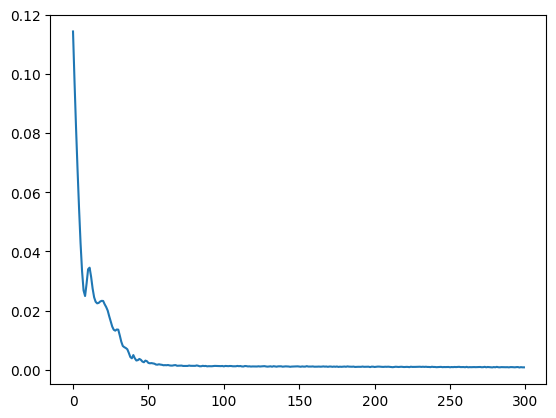

In [21]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

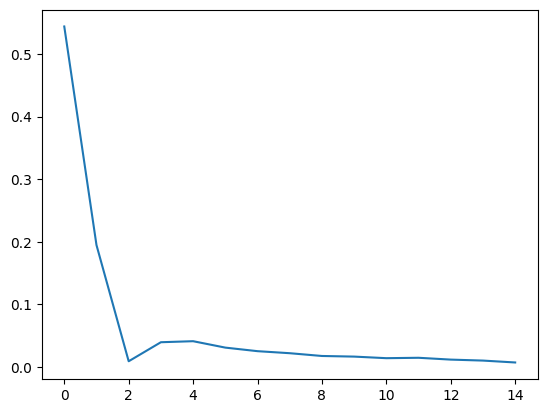

In [22]:
plt.plot(history_eval_loss)

In [23]:
X_test[0]

array([[0.53324732, 0.53097957, 0.5909131 , 0.5891313 , 0.59358582,
        0.60338576, 0.61342868]])

In [24]:
print(hidden_state)

None


In [27]:
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
y_test = np.reshape(y_test, (y_test.shape[0], 1, 1))
y_test_tensor = torch.Tensor(y_test)

In [28]:
print(F.mse_loss(test_predict, y_test_tensor))

tensor(0.0054, grad_fn=<MseLossBackward0>)


In [30]:
y_predict = test_predict.detach().numpy()

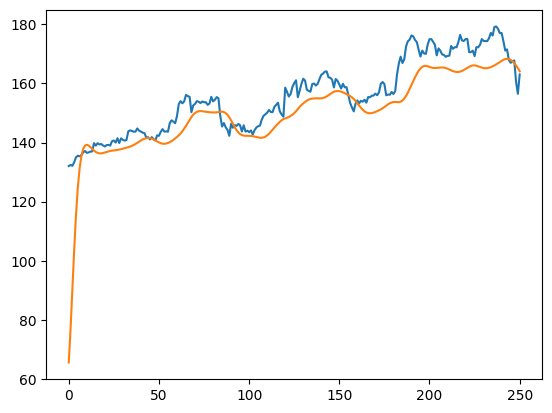

In [31]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_predict.reshape(-1,1)))

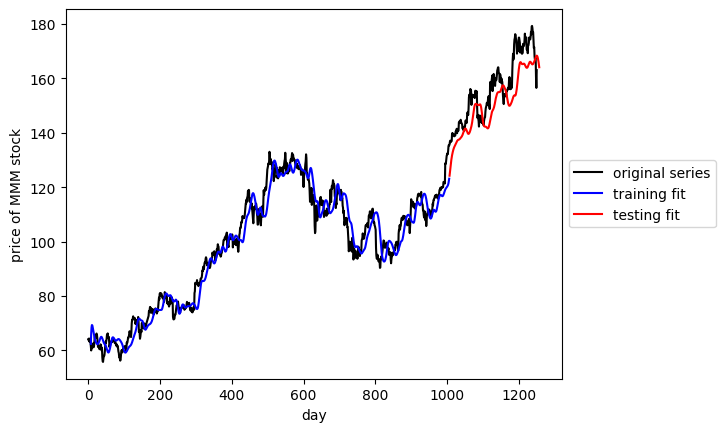

In [32]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
